In [24]:
# Install the necessary dependencies
!pip install selenium
!apt update
!apt install chromium-chromedriver


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
44 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

In [25]:
# Import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import re
import networkx as nx
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from wordcloud import STOPWORDS
from wordcloud import WordCloud

In [26]:
# Configure Chromedriver options
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Configure variables
_driver = webdriver.Chrome(options=options)
_url = "https://testdevjobs.com/location/remote-united-kingdom"

In [28]:
# Modified from @ https://colab.research.google.com/drive/14kXYQCSGVye4bBKKExtuHOeq32bc4xbW?usp=sharing#scrollTo=dRAMB1_yt1jJ

def getJobListings(driver: str, url: str):
  driver.get(url)
  job_listings = _driver.find_elements(By.XPATH, "//*[@class='job-deatils']")
  return job_listings

def fetchJobDetailsAndAddToList(driver: str, selector: str, empty_list):
  job_detail = driver.find_element(By.XPATH, selector).text
  empty_list.append(job_detail)

def traverseJobs(driver: str, url: str):
  job_listings = getJobListings(driver, url)
  job_count = 0
  job_title = []

  job_location = []
  job_skills = []
  job_id = []

  for job in job_listings:
    fetchJobDetailsAndAddToList(driver, "//*[@class='ml-5 jobtitle is-size-5 has-text-weight-semibold']", job_title)
    fetchJobDetailsAndAddToList(driver, "//*[@class='tags ml-5 mr-1 mb-0']", job_location)
    fetchJobDetailsAndAddToList(driver, "//*[@class='tags ml-5 mr-1']", job_skills)
    job_count =+ 1
    job_id.append(job_count)

  jobs_panda_frame = pd.DataFrame(list(zip(job_id, job_title, job_location, job_skills)), columns = ['ID', 'Title', 'Location', 'Skills'])
  return jobs_panda_frame.to_csv('jobs.csv')

traverseJobs(_driver, _url)

In [13]:
# Prepare data for Voyant processing

jobs_data = pd.read_csv("/content/jobs.csv")
skills_data = jobs_data["Skills"]
skills_data.head()

# Save into a new CSV file
skills_data.to_csv("skills.csv")

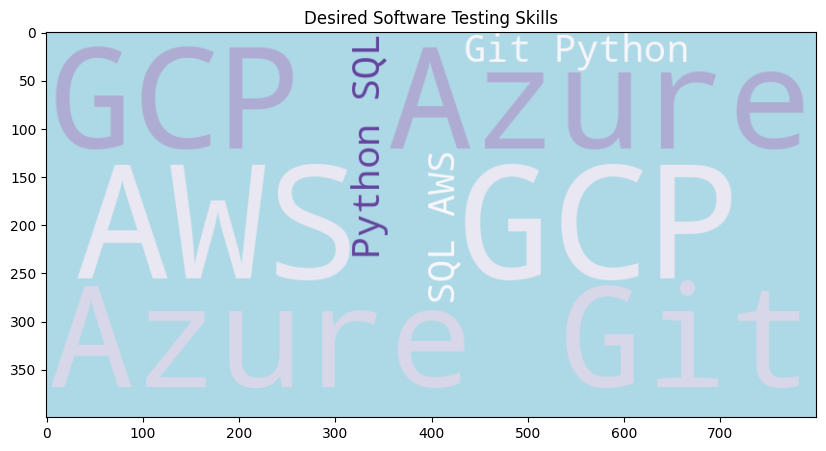

In [29]:
# Create a word cloud
text = " ".join(skills for skills in jobs_data.Skills.astype(str))
stopwords = set(STOPWORDS)
wordcloud = WordCloud().generate(text)

# Customise the word cloud
wordcloud = WordCloud(width=800, height=400, stopwords = stopwords, background_color='lightblue', max_words=100, colormap='Purples_r').generate(text) # https://www.geeksforgeeks.org/python/generating-word-cloud-python
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.title("Desired Software Testing Skills")
plt.show()

In [30]:
# Prepare data for Palladio processing before working with OpenRefine.

# Remove repetitions
jobs_data.drop_duplicates(inplace = True)
jobs_data.head()
jobs_data.to_csv("updated_jobs.csv")

location_data = jobs_data["Location"]
location_data.to_csv("locations.csv")
location_data.head()

,Location
0,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
1,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
2,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
3,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
4,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time


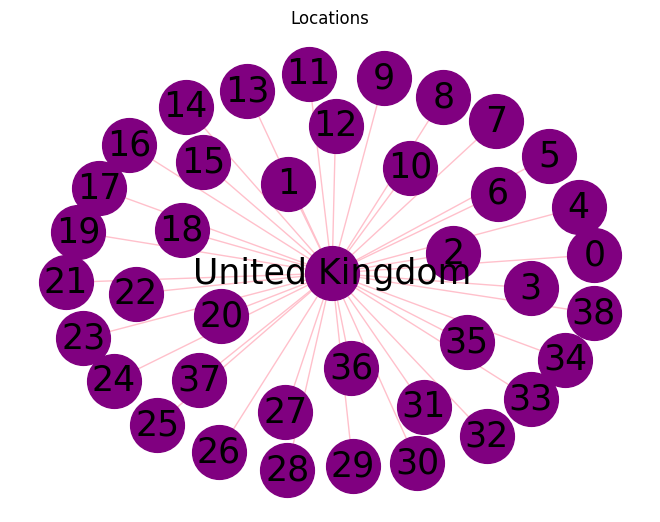

In [31]:
# Load CSV exported from OpenRefine
locations_csv = pd.read_csv("/content/locations_for_palladio.csv")
locations_csv.head()

# Create a network graph @ https://medium.com/@harshkjoya/connecting-the-dots-creating-network-graphs-from-pandas-dataframes-with-networkx-9c4fb60089cf
G = nx.Graph()
G.add_nodes_from(locations_csv['Column'])
G.add_nodes_from(locations_csv['Location'])
edges = [(row['Column'], row['Location']) for index, row in locations_csv.iterrows()]
G.add_edges_from(edges)

# Draw the graph
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='purple', font_size=25, font_color='black', edge_color="pink")
plt.title("Locations")
plt.show()

In [32]:
# Code generated from Microsoft Copilot (with noted modifications)

# REMOVED IMPORTS

# Load data
file_path = '/content/updated_jobs.csv' # MODIFIED
df = pd.read_csv(file_path)

# Ensure output directory exists
output_dir = '/content' # MODIFIED
os.makedirs(output_dir, exist_ok=True)

# --- Word Cloud ---
# Extract and clean skills
skills_series = df['Skills'].dropna().apply(lambda x: x.split('\n'))
skills_flat = [skill.strip() for sublist in skills_series for skill in sublist]
skills_text = ' '.join(skills_flat)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Desirable Skills Word Cloud')
wordcloud_path = os.path.join(output_dir, 'wordcloud.png')
plt.savefig(wordcloud_path)
plt.close()

# --- Network Graph ---
# Create co-occurrence edges
from itertools import combinations, chain

edges = []
for skills in skills_series:
    skills = [skill.strip() for skill in skills]
    edges.extend(combinations(skills, 2))

# Count edge frequencies
from collections import Counter
edge_counts = Counter(edges)

# Build graph
G = nx.Graph()
for (skill1, skill2), weight in edge_counts.items():
    G.add_edge(skill1, skill2, weight=weight)

# Draw graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges])
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Skill Co-occurrence Network Graph')
network_path = os.path.join(output_dir, 'network_graph.png')
plt.savefig(network_path)
plt.close()

# --- UK Map with Remote Marker ---
import geopandas as gpd
from shapely.geometry import Point

# Load UK map # MODIFIED https://github.com/mattijn/topojson/issues/224
world = gpd.read_file(
    "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
uk = world[world.name == 'United Kingdom']

# Create dummy point for remote jobs
remote_point = gpd.GeoDataFrame([{'geometry': Point(-1.5, 54.0), 'Location': 'Remote'}], crs='EPSG:4326')

# Plot map
fig, ax = plt.subplots(figsize=(8, 10))
uk.plot(ax=ax, color='lightgrey')
remote_point.plot(ax=ax, color='red', markersize=100)
plt.title('Job Locations in the UK (Remote Highlighted)')
map_path = os.path.join(output_dir, 'uk_map.png')
plt.savefig(map_path)
plt.close()